In [1]:
import sys
import os

sys.path.append('/home/v_chernyy/thesis')

from models.seg_wrapper import LitSegNet

from torchvision import transforms as TT
from data import get_train_test_split_paired_loaders

from models.gans.cycle_gan.model import GAN

import pytorch_lightning as pl
import torch

from models.utils import pad_tensor, unpad_tensor
import infer_utils

import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

import yaml

import warnings
warnings.filterwarnings('ignore')


with open('configs/infer_gan.yaml') as f:
    params_dict = yaml.safe_load(f)
    
print(params_dict)

{'data': {'batch_size': 1, 'df_from': {'data_path': '/home/v_chernyy/thesis/dataframes/siemens15.csv'}, 'df_to': {'data_path': '/home/v_chernyy/thesis/dataframes/philips15.csv'}}, 'gan_model': {'checkpoint_path': 'checkpoints/siemens15->philips15_gan.ckpt'}, 'task_model': {'checkpoint_path': '/home/v_chernyy/thesis/checkpoints/philips15_unet.ckpt'}, 'trainer': {'accelerator': 'gpu', 'devices': [0]}}


In [4]:
train_transform =  None # TT.Compose([
#         TT.Resize((256, 256)),
#         TT.CenterCrop((256, 256))
# ]) 
# TT.Resize((256, 256))

_, test_loader = get_train_test_split_paired_loaders(
    params_dict['data'],
    train_transform=train_transform,
    test_transform=train_transform
)

if torch.cuda.is_available():
    DEVICE = torch.device('cuda:{}'.format(*params_dict['trainer']['devices']))
else:
    raise Exception

gan_model = GAN.load_from_checkpoint(checkpoint_path=params_dict['gan_model']['checkpoint_path']).to(DEVICE).eval()

task_model = LitSegNet.load_from_checkpoint(checkpoint_path=params_dict['task_model']['checkpoint_path']).to(DEVICE).eval()

d_from = params_dict['data']['df_from']['data_path'].split('/')[-1].split('.')[0]
d_to = params_dict['data']['df_to']['data_path'].split('/')[-1].split('.')[0]

with torch.no_grad():

    trainer = pl.Trainer(**params_dict['trainer'])

    predictions = trainer.predict(gan_model, test_loader)

    fake_to_batches = [fake_to for fake_to, fake_from in predictions]

Lightning automatically upgraded your loaded checkpoint from v1.8.1 to v2.0.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../checkpoints/philips15_unet.ckpt`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

In [5]:
with torch.no_grad():

    avg_sds = 0.

    for fake_to_batch, true_batch in tqdm(zip(fake_to_batches, test_loader), total=len(test_loader)):
        
        batch_from, batch_to = true_batch

        # x = task_model(torch.tensor(pad_tensor(batch_to['img'].cpu())).to(DEVICE))

        # print(x.shape)
        # print(fake_from_batch.shape)
        fake_to_batch = fake_to_batch.to(DEVICE)

        x = task_model(fake_to_batch)
        out = unpad_tensor(x, batch_from['img']).squeeze(1)
        # out = task_model(out).squeeze(1)
        
        pred_mask = (torch.sigmoid(out) > 0.5).long()
        
        src_mask = batch_to['mask'].squeeze(1)

        # print(pred_mask.shape, src_mask.shape)

        sds_metric = np.mean([task_model.surface_dice_score(x, y) for x, y in zip(pred_mask, src_mask)])
        avg_sds += sds_metric
        print(sds_metric)

        # print(sds_metric)

    avg_sds = avg_sds / len(test_loader)

    print('\nAverage Surface Dice Score:', avg_sds)

    os.makedirs('inference_results/', exist_ok=True)

    chkpt_name = params_dict['task_model']['checkpoint_path'].split('/')[-1].split('.')[0]

    df_from = chkpt_name.split('_')[0]
    df_to = d_to

    df_path = 'inference_results/cycle_gan.csv'

    if os.path.isfile(df_path):
        df = pd.read_csv(df_path, index_col=0)
    else:
        df = infer_utils.create_df()

    print(df_from, df_to)

    if df_from not in df.index:
        df_new_row = pd.DataFrame(pd.Series({df_from: avg_sds}, name=df_to), columns=df.columns)
        df = pd.concat([df, df_new_row])
    else:
        df.loc[df.index == df_from, df_to] = avg_sds
    
    df.to_csv(df_path)


  0%|          | 0/280 [00:00<?, ?it/s]

0.45485288586228223
0.45087132961311915
0.4348067384308709
0.35553775477231875
0.29863950667012007
0.331703502145143
0.2704822244468119
0.2811393497275973
0.30025136300005173
0.26310203540893806
0.2894617477719421
0.3282252856267823
0.27511191047756123
0.251503302494072
0.2721777851932837
0.25574109357474967
0.2729995415071407
0.29717230593591054
0.2997432785437798
0.2734687282602966
0.2753064573936242
0.2750335818337041
0.2526302753146509
0.26025507072451587
0.2616206461563208
0.23923160035124982
0.26153223715070045
0.28880983044854974
0.2874409967713943
0.2723574526104511
0.28522550330417307
0.284048508242691
0.25686524407284844
0.25758755733453326
0.24355621900538954
0.27665678623108125
0.2903658909092505
0.3501190381968173
0.36425221296790133
0.3239999774306199
0.3889004135025853
0.4067172647898749
0.43244203540426446
0.4413898612547597
0.40503187574323934
0.4144635649868285
0.4131279319045143
0.43002362826261986
0.3989188733521598
0.43430832719363305
0.46154105029995873
0.44967179

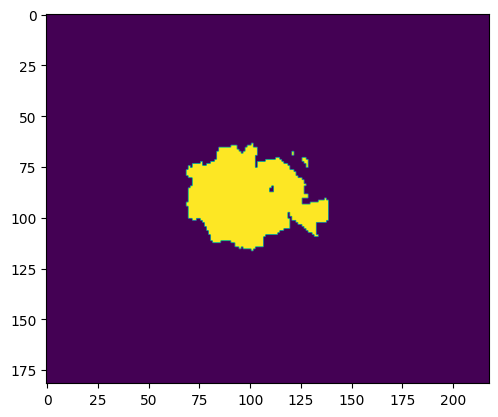

In [8]:
import matplotlib.pyplot as plt

# plt.imshow(pred_mask.cpu().squeeze())
plt.imshow(src_mask.cpu().squeeze())

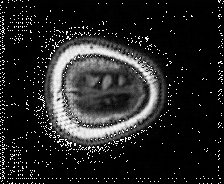

In [29]:
TT.ToPILImage()(fake_to_batch.squeeze())

In [24]:
x = task_model(fake_to_batch)
out = unpad_tensor(x, batch_to['img']).squeeze(1)

pred_mask = (torch.sigmoid(out) > 0.5).long()

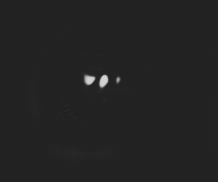

In [25]:
TT.ToPILImage()(torch.sigmoid(out).squeeze())

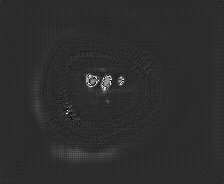

In [26]:
TT.ToPILImage()(x.squeeze())